<a href="https://colab.research.google.com/github/MorozovDesu/neural_network_technologies/blob/main/2_%D0%9B%D0%B0%D0%B1%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B2%D1%8B%D0%B5_%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import os
import h5py
import PIL
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams["figure.figsize"] = (14,8)

# Обучение нейросети с использованием keras
Желаемый результат

а=>1, б=>2, в=>3, г=>4, д=>5, е=>6, ё=>7, ж=>8, з=>9, и=>10, й=>11, к=>12, л=>13, м=>14, н=>15, о=>16, п=>17, р=>18, с=>19, т=>20, у=>21, ф=>22, х=>23, ц=>24, ч=>25, ш=>26, щ=>27, ъ=>28, ы=>29, ь=>30, э=>31, ю=>32, я=>33

In [ ]:
input_folder = 'drive/MyDrive/archive/all_letters_image/all_letters_image/'
all_letters_filename = os.listdir(input_folder)
len(all_letters_filename)

14190

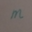

In [ ]:
#Это одно из наших изображений. Размер каждого изображения составляет 32 на 32 пикселя.
#Затем мы преобразуем каждое изображение в 3d-массив numpy.
i = Image.open("drive/MyDrive/archive/all_letters_image/all_letters_image/20_102.png")
i

In [ ]:
i_arr = np.array(i)
# i_arr
# Все 32 матрицы внутри этого массива представляют собой одно изображение.
# Каждая матрица представляет собой 1 строку этого изображения.
# Длина одной строки изображения составляет 32 пикселя, поэтому каждая матрица имеет 32 строки.
# Каждая строка матрицы имеет 4 столбца и представляет собой 1 пиксель. Для этого пикселя каждый столбец представляет собой значения цвета - насколько он красный, зеленый и синий - плюс непрозрачность цветов (последний столбец).
# Поэтому каждая матрица имеет размер 32 на 4. Общее количество пикселей в одном изображении составляет 32 * 32 = 1024.

# Каждое значение цвета находится в диапазоне [0:255].
# Это означает, что для каждого цвета существует 256 оттенков. В сумме все комбинации этих цветов дают нам 256ˆ3 = 16 777 216 возможных цветов.



In [ ]:
from keras.preprocessing import image
import numpy as np

# Функция для преобразования изображения в тензор
# Параметры:
# - img_name: Имя файла изображения
# - input_folder: Путь к папке, где находится изображение
# Возвращает:
# - Тензорное представление изображения
def img_to_array(img_name, input_folder):
    # Загрузка изображения из указанной папки и изменение его размера до 32x32 пикселей
    img = image.load_img(input_folder + img_name, target_size=(32, 32))

    # Преобразование изображения в массив NumPy
    x = image.img_to_array(img)

    # Расширение размерности массива для подготовки его к обработке нейронной сетью
    return np.expand_dims(x, axis=0)

# Функция для преобразования списка имен изображений в тензор
# Параметры:
# - img_names: Список имен файлов изображений
# - input_folder: Путь к папке, где находятся изображения
# Возвращает:
# - Массив NumPy, содержащий тензоры всех изображений из списка
def data_to_tensor(img_names, input_folder):
    # Создание списка тензоров путем применения функции img_to_array к каждому имени изображения
    list_of_tensors = [img_to_array(img_name, input_folder) for img_name in img_names]

    # Стекирование отдельных тензоров вертикально для создания одного массива NumPy
    return np.vstack(list_of_tensors)


In [ ]:
# Загрузка данных из CSV-файла в переменную "data"
data = pd.read_csv("drive/MyDrive/archive/all_letters_info.csv")
# Извлечение имен файлов изображений из столбца "file"
image_names = data['file']
letters = data[ 'letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(image_names, input_folder)
# tensors[0]


In [ ]:
# Вывод размера (формы) массива тензоров
print('Форма тензоров:', tensors.shape)
# Вывод размера (формы) массива меток (целевых значений)
print('Форма меток (целевых значений):', targets.shape)

Форма тензоров: (14190, 32, 32, 3)
Форма меток (целевых значений): (14190,)


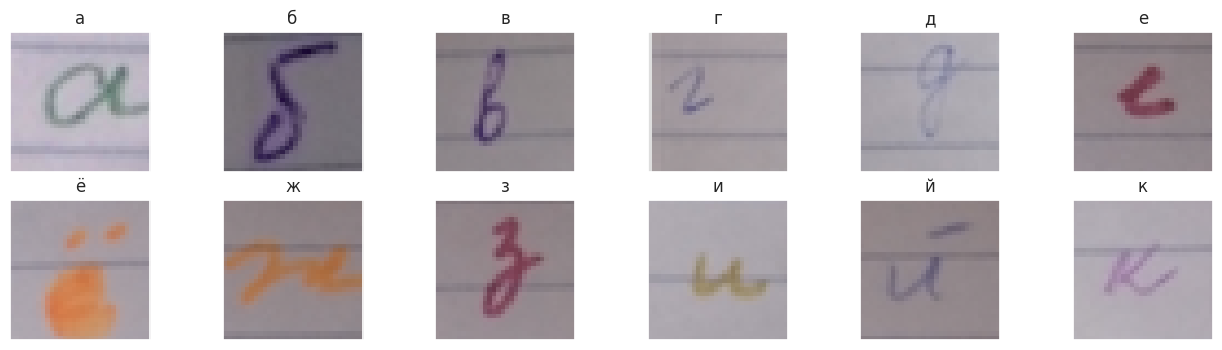

In [ ]:
# Функция для отображения изображений из файлов с использованием OpenCV
# Параметры:
# - img_path: Путь к файлу изображения
# - ax: Объект для отображения изображения (область на графике)
def display_images(img_path, ax):
    # Загрузка изображения из указанного пути
    img = cv2.imread(input_folder + img_path)

    # Отображение изображения, преобразовав его из формата BGR в RGB
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Создание графического окна с определенными размерами
fig = plt.figure(figsize=(16, 4))

# Цикл для отображения 12 изображений
for i in range(12):
    # Создание области для каждого изображения внутри графического окна
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i * 50])

    # Вызов функции для отображения изображения с указанным именем файла и заданной областью (ax)
    display_images(image_names[i * 50], ax)

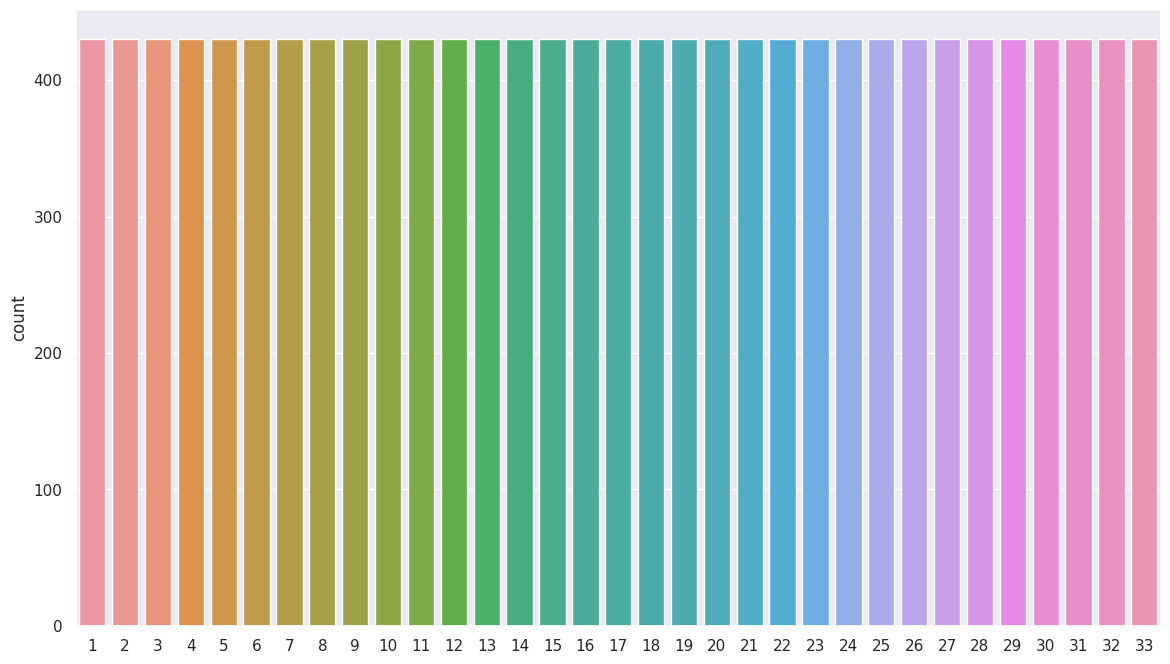

In [ ]:
# Создание графика countplot
sns.set(style="darkgrid")
ax = sns.countplot(x=targets)

# Отображение графика
plt.show()

In [ ]:
# Классы идеально сбалансированы, что очень важно для классификационной модели.
# Если классы несбалансированы, то модель будет пытаться максимизировать точность
# для большинства классов, оставляя без внимания другие классы, что приведет к менее точным прогнозам для меньшинств.

In [ ]:
# Нормализация
# Для уменьшения влияния перепадов освещенности мы проводим нормализацию.
X = tensors.astype("float32")/255
# Кроме того, CNN быстрее сходится на данных [0...1], чем на [0...255]. Преобразуем входные данные к типу float, а затем разделим на 255 (максимальная яркость для каждого цвета).

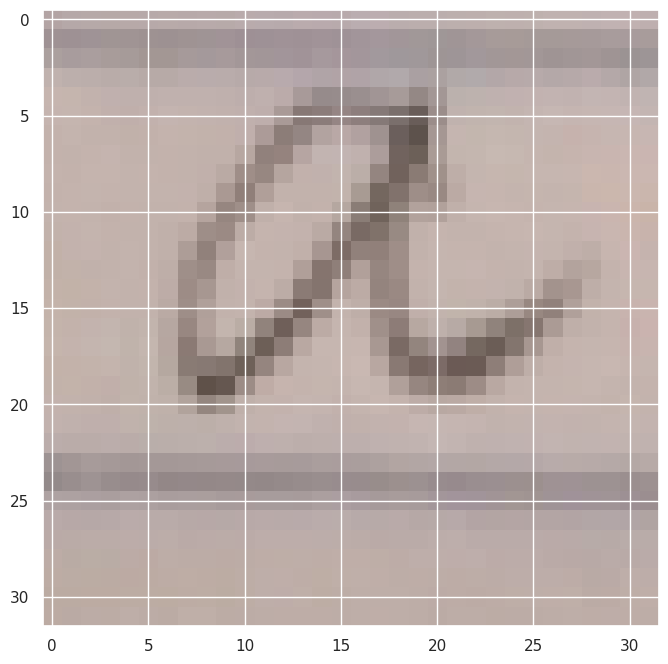

In [ ]:
arr = X[2]
arr_ = np.squeeze(arr)
plt.imshow(arr_)
plt.show()

In [ ]:
targets[0]

1

In [ ]:
y = targets

img_rows, img_cols = 32, 32 # потому что наши картинки имеют размер 32 на 32 пикселя
num_classes = 33 # потому что в русинском алфавите 33 буквы

y = keras.utils.to_categorical(y-1, num_classes) # targets-1, потому что наш список начинается с 1, а не с 0, как ожидает keras

In [ ]:
print(X.shape)
print(y.shape)

(14190, 32, 32, 3)
(14190, 33)


In [ ]:
def captch_ex(file_name):
    img = cv2.imread(file_name)
    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # для черного текста использовать cv2.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # для манипуляции ориентацией расширения, большое значение x означает большее горизонтальное расширение, большое значение y означает большее вертикальное расширение
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # расширяем, чем больше итераций, тем больше расширение
    # for cv2.x.x

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)   # findContours возвращает 3 переменные для получения контуров
    for contour in contours:
        #  получаем ограничивающий прямоугольник контура
        [x, y, w, h] = cv2.boundingRect(contour)

        # Не рисуем маленькие контуры, которые не являются текстом
        if w < 35 and h < 35:
            continue

        # рисуем прямоугольник вокруг контура на исходном изображении
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.png'
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # записываем исходное изображение с добавленными контурами на диск
    cv2.imshow('captcha_result', img)
    cv2.waitKey()

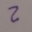

In [ ]:
file_name = 'drive/MyDrive/archive/all_letters_image/all_letters_image/04_100.png'
# captch_ex(file_name)

In [ ]:
# Тензоры с градацией серого
X_grey = np.dot(X[...,:3], [0.299, 0.587, 0.114])
# X_grey = tf.expand_dims(X_grey, axis=3)
print ('Grayscaled Tensor shape:', X_grey.shape)

Grayscaled Tensor shape: (14190, 32, 32)


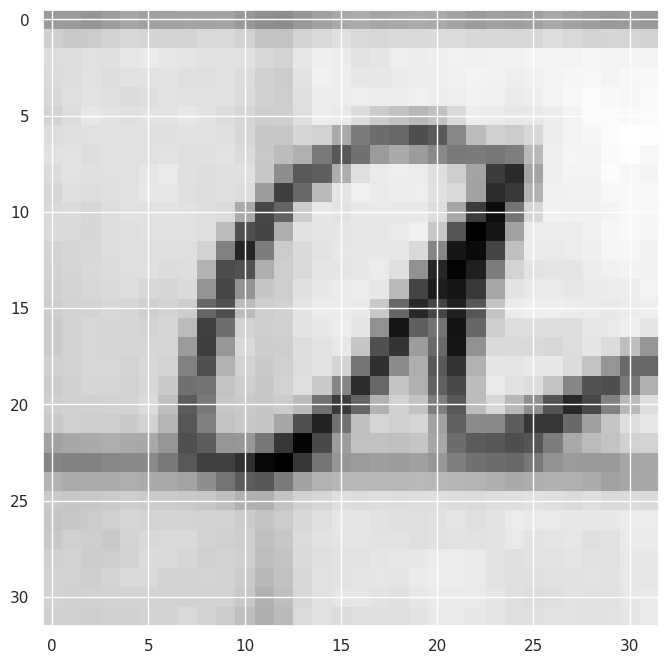

In [ ]:
plt.imshow(X_grey[3], cmap=plt.get_cmap("gray"))

In [ ]:
# Разделение набора данных на обучающую и тестовую выборки
# X: признаки/входные данные
# y: метки/целевые значения

# Разделение X и y на обучающую и тестовую выборки с размером тестовой выборки 10%
# random_state=1 гарантирует воспроизводимость результатов
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Дальнейшее разделение обучающей выборки на обучающую и проверочную выборки
# X_train_whole: полный набор признаков обучающей выборки
# y_train_whole: полный набор меток обучающей выборки

# Разделение X_train_whole и y_train_whole на обучающую и проверочную выборки с размером проверочной выборки 10%
# random_state=1 гарантирует воспроизводимость результатов
X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.1, random_state=1)

In [ ]:
# Создание генератора данных для аугментации изображений
datagen = ImageDataGenerator(
    featurewise_center=False,  # установить среднее значение входных данных равным 0 по всему набору данных
    samplewise_center=False,  # установить среднее значение каждого отдельного образца/изображения равным 0
    featurewise_std_normalization=False,  # нормализовать входные данные путем деления на стандартное отклонение набора данных
    samplewise_std_normalization=False,  # нормализовать каждый вход путем деления на его стандартное отклонение
    zca_whitening=False,  # применить ZCA-отбеливание
    rotation_range=10,  # случайное вращение изображений в заданном диапазоне (градусы, от 0 до 180)
    zoom_range=0.1,  # случайное изменение масштаба изображения
    width_shift_range=0.1,  # случайное смещение изображений по горизонтали (доля от общей ширины)
    height_shift_range=0.1,  # случайное смещение изображений по вертикали (доля от общей высоты)
    horizontal_flip=False,  # случайное отражение изображений по горизонтали
    vertical_flip=False)  # случайное отражение изображений по вертикали

# Подготовка генератора к обучающему набору данных
datagen.fit(X_train)

In [ ]:
#Определение архитектуры модели

deep_RU_model = Sequential()
#Добавление первого слоя свертки
#filters: количество фильтров (ядер)
#kernel_size: размер ядра свертки
#padding: режим заполнения ('Same' - добавление нулевых значений по краям изображения)
#activation: функция активации ('relu' - выпрямительная функция)
#input_shape: размерность входных данных (img_rows, img_cols, 3) - 3 канала (RGB)
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (img_rows,img_cols,3)))
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
deep_RU_model.add(Dropout(0.25))

#Выравнивание данных перед подачей на полносвязные слои
deep_RU_model.add(Flatten())
#Добавление первого полносвязного слоя
deep_RU_model.add(Dense(256, activation = "relu"))
#Добавление слоя Dropout
deep_RU_model.add(Dropout(0.5))
#Добавление последнего полносвязного слоя с функцией активации softmax для многоклассовой классификации
deep_RU_model.add(Dense(33, activation = "softmax"))

In [ ]:
#Определение оптимизатора
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

#Создание оптимизатора RMSprop с параметрами:
#learning_rate: скорость обучения (шаг градиентного спуска)
#rho: параметр альфа в формуле оптимизации
#epsilon: значение для стабильности численных вычислений

In [ ]:
deep_RU_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Компиляция модели с параметрами:
# loss: функция потерь ("categorical_crossentropy" - категориальная перекрестная энтропия для многоклассовой классификации)
# optimizer: оптимизатор, ранее определенный (RMSprop)
# metrics: список метрик для оценки производительности модели (в данном случае указана только точность)

In [ ]:
# Создание объекта learning_rate_reduction класса ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
# monitor: метрика для отслеживания (в данном случае 'val_acc' - точность на валидационных данных)
# patience: количество эпох без улучшений, после которого скорость обучения будет уменьшена
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# factor: коэффициент, на который будет уменьшаться скорость обучения
# min_lr: минимальное значение скорости обучения, после которого обучение прекращается

In [ ]:
# Создание объекта es класса EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
# monitor: метрика для отслеживания (в данном случае 'val_accuracy' - точность на валидационных данных)
# mode: режим ('max' - максимизация метрики)
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# patience: количество эпох без улучшений, после которого обучение будет остановлено

# Создание объекта mc класса ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# 'best_model.h5': имя файла, в котором будет сохранена модель с лучшей точностью на валидационных данных
# monitor: метрика для отслеживания (в данном случае 'val_accuracy' - точность на валидационных данных)
# mode: режим ('max' - максимизация метрики)
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# save_best_only: флаг, указывающий, сохранять только модель с лучшей точностью

In [ ]:
history = deep_RU_model.fit(datagen.flow(X_train,y_train, batch_size=90), validation_data = (X_val, y_val),
                            epochs=139, callbacks=[learning_rate_reduction, es, mc])
# datagen.flow(X_train, y_train, batch_size=90): генератор данных для обучения модели, созданный с использованием данных X_train и y_train
# X_train: входные данные для обучения
# y_train: целевые данные для обучения
# batch_size: размер пакета данных, на котором будут обновляться веса модели
# validation_data=(X_val, y_val): данные для проверки производительности модели на каждой эпохе обучения
# X_val: входные данные для проверки
# y_val: целевые данные для проверки
# epochs: количество эпох обучения
# callbacks=[learning_rate_reduction, es, mc]: список колбэков, которые будут выполняться на различных этапах обучения
# learning_rate_reduction: уменьшение скорости обучения при отсутствии улучшений
# es: ранняя остановка обучения при отсутствии улучшений
# mc: сохранение модели с лучшей точностью на валидационных данных

Epoch 1/139
128/128 [==============================] - ETA: 0s - loss: 3.4984 - accuracy: 0.0298


Epoch 1: val_accuracy improved from -inf to 0.04773, saving model to best_model.h5
128/128 [==============================] - 124s 959ms/step - loss: 3.4984 - accuracy: 0.0298 - val_loss: 3.4937 - val_accuracy: 0.0477 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/139
128/128 [==============================] - ETA: 0s - loss: 3.4790 - accuracy: 0.0379


Epoch 2: val_accuracy improved from 0.04773 to 0.05869, saving model to best_model.h5
128/128 [==============================] - 112s 875ms/step - loss: 3.4790 - accuracy: 0.0379 - val_loss: 3.4218 - val_accuracy: 0.0587 - lr: 0.0010
Epoch 3/139
128/128 [==============================] - ETA: 0s - loss: 3.4222 - accuracy: 0.0504


Epoch 3: val_accuracy did not improve from 0.05869
128/128 [==============================] - 120s 934ms/step - loss: 3.4222 - accuracy: 0.0504 - val_loss: 3.4169 - val_accuracy: 0.0509 - lr: 0.0010
Epoch 4/139
128/128 [==============================] - ETA: 0s - loss: 3.3839 - accuracy: 0.0536


Epoch 4: val_accuracy did not improve from 0.05869
128/128 [==============================] - 112s 874ms/step - loss: 3.3839 - accuracy: 0.0536 - val_loss: 3.4077 - val_accuracy: 0.0509 - lr: 0.0010
Epoch 5/139
128/128 [==============================] - ETA: 0s - loss: 3.3585 - accuracy: 0.0626


Epoch 5: val_accuracy improved from 0.05869 to 0.07433, saving model to best_model.h5
128/128 [==============================] - 113s 875ms/step - loss: 3.3585 - accuracy: 0.0626 - val_loss: 3.2727 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 6/139
128/128 [==============================] - ETA: 0s - loss: 3.3236 - accuracy: 0.0698


Epoch 6: val_accuracy improved from 0.07433 to 0.08529, saving model to best_model.h5
128/128 [==============================] - 113s 884ms/step - loss: 3.3236 - accuracy: 0.0698 - val_loss: 3.2442 - val_accuracy: 0.0853 - lr: 0.0010
Epoch 7/139
128/128 [==============================] - ETA: 0s - loss: 3.2884 - accuracy: 0.0741


Epoch 7: val_accuracy improved from 0.08529 to 0.10250, saving model to best_model.h5
128/128 [==============================] - 119s 929ms/step - loss: 3.2884 - accuracy: 0.0741 - val_loss: 3.1778 - val_accuracy: 0.1025 - lr: 0.0010
Epoch 8/139
128/128 [==============================] - ETA: 0s - loss: 3.2323 - accuracy: 0.0937


Epoch 8: val_accuracy improved from 0.10250 to 0.11894, saving model to best_model.h5
128/128 [==============================] - 113s 880ms/step - loss: 3.2323 - accuracy: 0.0937 - val_loss: 3.1121 - val_accuracy: 0.1189 - lr: 0.0010
Epoch 9/139
128/128 [==============================] - ETA: 0s - loss: 3.1577 - accuracy: 0.1141


Epoch 9: val_accuracy improved from 0.11894 to 0.15649, saving model to best_model.h5
128/128 [==============================] - 110s 862ms/step - loss: 3.1577 - accuracy: 0.1141 - val_loss: 3.0320 - val_accuracy: 0.1565 - lr: 0.0010
Epoch 10/139
128/128 [==============================] - ETA: 0s - loss: 2.9850 - accuracy: 0.1555


Epoch 10: val_accuracy improved from 0.15649 to 0.33412, saving model to best_model.h5
128/128 [==============================] - 110s 863ms/step - loss: 2.9850 - accuracy: 0.1555 - val_loss: 2.5200 - val_accuracy: 0.3341 - lr: 0.0010
Epoch 11/139
128/128 [==============================] - ETA: 0s - loss: 2.7520 - accuracy: 0.2202


Epoch 11: val_accuracy improved from 0.33412 to 0.39437, saving model to best_model.h5
128/128 [==============================] - 110s 863ms/step - loss: 2.7520 - accuracy: 0.2202 - val_loss: 2.1840 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 12/139
128/128 [==============================] - ETA: 0s - loss: 2.5191 - accuracy: 0.2773


Epoch 12: val_accuracy improved from 0.39437 to 0.51721, saving model to best_model.h5
128/128 [==============================] - 111s 870ms/step - loss: 2.5191 - accuracy: 0.2773 - val_loss: 1.8821 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 13/139
128/128 [==============================] - ETA: 0s - loss: 2.2710 - accuracy: 0.3425


Epoch 13: val_accuracy did not improve from 0.51721
128/128 [==============================] - 113s 875ms/step - loss: 2.2710 - accuracy: 0.3425 - val_loss: 2.0812 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 14/139
128/128 [==============================] - ETA: 0s - loss: 2.0798 - accuracy: 0.4013


Epoch 14: val_accuracy improved from 0.51721 to 0.69562, saving model to best_model.h5
128/128 [==============================] - 112s 875ms/step - loss: 2.0798 - accuracy: 0.4013 - val_loss: 1.1487 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 15/139
128/128 [==============================] - ETA: 0s - loss: 1.8268 - accuracy: 0.4676


Epoch 15: val_accuracy improved from 0.69562 to 0.73083, saving model to best_model.h5
128/128 [==============================] - 114s 891ms/step - loss: 1.8268 - accuracy: 0.4676 - val_loss: 0.9991 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 16/139
128/128 [==============================] - ETA: 0s - loss: 1.6560 - accuracy: 0.5194


Epoch 16: val_accuracy improved from 0.73083 to 0.73552, saving model to best_model.h5
128/128 [==============================] - 111s 866ms/step - loss: 1.6560 - accuracy: 0.5194 - val_loss: 0.9965 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 17/139
128/128 [==============================] - ETA: 0s - loss: 1.4806 - accuracy: 0.5696


Epoch 17: val_accuracy improved from 0.73552 to 0.80203, saving model to best_model.h5
128/128 [==============================] - 110s 863ms/step - loss: 1.4806 - accuracy: 0.5696 - val_loss: 0.7762 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 18/139
128/128 [==============================] - ETA: 0s - loss: 1.3401 - accuracy: 0.6058


Epoch 18: val_accuracy improved from 0.80203 to 0.81299, saving model to best_model.h5
128/128 [==============================] - 115s 896ms/step - loss: 1.3401 - accuracy: 0.6058 - val_loss: 0.6372 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 19/139
128/128 [==============================] - ETA: 0s - loss: 1.2356 - accuracy: 0.6429


Epoch 19: val_accuracy did not improve from 0.81299
128/128 [==============================] - 111s 868ms/step - loss: 1.2356 - accuracy: 0.6429 - val_loss: 0.7175 - val_accuracy: 0.7934 - lr: 0.0010
Epoch 20/139
128/128 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.6673


Epoch 20: val_accuracy improved from 0.81299 to 0.82551, saving model to best_model.h5
128/128 [==============================] - 115s 897ms/step - loss: 1.1281 - accuracy: 0.6673 - val_loss: 0.5957 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 21/139
128/128 [==============================] - ETA: 0s - loss: 1.0645 - accuracy: 0.6835


Epoch 21: val_accuracy improved from 0.82551 to 0.85211, saving model to best_model.h5
128/128 [==============================] - 113s 880ms/step - loss: 1.0645 - accuracy: 0.6835 - val_loss: 0.5173 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 22/139
128/128 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.7043


Epoch 22: val_accuracy did not improve from 0.85211
128/128 [==============================] - 119s 931ms/step - loss: 1.0051 - accuracy: 0.7043 - val_loss: 0.5356 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 23/139
128/128 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.7177


Epoch 23: val_accuracy improved from 0.85211 to 0.88185, saving model to best_model.h5
128/128 [==============================] - 111s 869ms/step - loss: 0.9510 - accuracy: 0.7177 - val_loss: 0.3938 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 24/139
128/128 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.7299


Epoch 24: val_accuracy improved from 0.88185 to 0.88498, saving model to best_model.h5
128/128 [==============================] - 110s 862ms/step - loss: 0.9038 - accuracy: 0.7299 - val_loss: 0.4403 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 25/139
128/128 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.7514


Epoch 25: val_accuracy did not improve from 0.88498
128/128 [==============================] - 111s 866ms/step - loss: 0.8433 - accuracy: 0.7514 - val_loss: 0.5068 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 26/139
128/128 [==============================] - ETA: 0s - loss: 0.7997 - accuracy: 0.7616


Epoch 26: val_accuracy improved from 0.88498 to 0.91080, saving model to best_model.h5
128/128 [==============================] - 111s 865ms/step - loss: 0.7997 - accuracy: 0.7616 - val_loss: 0.3258 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 27/139
128/128 [==============================] - ETA: 0s - loss: 0.7841 - accuracy: 0.7645


Epoch 27: val_accuracy did not improve from 0.91080
128/128 [==============================] - 113s 876ms/step - loss: 0.7841 - accuracy: 0.7645 - val_loss: 0.4020 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 28/139
128/128 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.7807


Epoch 28: val_accuracy did not improve from 0.91080
128/128 [==============================] - 110s 863ms/step - loss: 0.7409 - accuracy: 0.7807 - val_loss: 0.3448 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 29/139
128/128 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.7844


Epoch 29: val_accuracy did not improve from 0.91080
128/128 [==============================] - 111s 864ms/step - loss: 0.7119 - accuracy: 0.7844 - val_loss: 0.3270 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 30/139
128/128 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.7914


Epoch 30: val_accuracy did not improve from 0.91080
128/128 [==============================] - 111s 865ms/step - loss: 0.6937 - accuracy: 0.7914 - val_loss: 0.3425 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 31/139
128/128 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.8011


Epoch 31: val_accuracy improved from 0.91080 to 0.91158, saving model to best_model.h5
128/128 [==============================] - 113s 882ms/step - loss: 0.6590 - accuracy: 0.8011 - val_loss: 0.2969 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 32/139
128/128 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.8089


Epoch 32: val_accuracy did not improve from 0.91158
128/128 [==============================] - 111s 864ms/step - loss: 0.6365 - accuracy: 0.8089 - val_loss: 0.3091 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 33/139
128/128 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.8088


Epoch 33: val_accuracy did not improve from 0.91158
128/128 [==============================] - 110s 861ms/step - loss: 0.6306 - accuracy: 0.8088 - val_loss: 0.3261 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 34/139
128/128 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.8175


Epoch 34: val_accuracy did not improve from 0.91158
128/128 [==============================] - 111s 866ms/step - loss: 0.6127 - accuracy: 0.8175 - val_loss: 0.3136 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 35/139
128/128 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.8226


Epoch 35: val_accuracy improved from 0.91158 to 0.92645, saving model to best_model.h5
128/128 [==============================] - 111s 865ms/step - loss: 0.5926 - accuracy: 0.8226 - val_loss: 0.2345 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 36/139
128/128 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.8202


Epoch 36: val_accuracy did not improve from 0.92645
128/128 [==============================] - 110s 860ms/step - loss: 0.5940 - accuracy: 0.8202 - val_loss: 0.2390 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 37/139
128/128 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.8281


Epoch 37: val_accuracy improved from 0.92645 to 0.93271, saving model to best_model.h5
128/128 [==============================] - 113s 884ms/step - loss: 0.5736 - accuracy: 0.8281 - val_loss: 0.2210 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 38/139
128/128 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.8370


Epoch 38: val_accuracy did not improve from 0.93271
128/128 [==============================] - 110s 863ms/step - loss: 0.5516 - accuracy: 0.8370 - val_loss: 0.2394 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 39/139
128/128 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8360


Epoch 39: val_accuracy did not improve from 0.93271
128/128 [==============================] - 111s 866ms/step - loss: 0.5427 - accuracy: 0.8360 - val_loss: 0.2266 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 40/139
128/128 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8423


Epoch 40: val_accuracy did not improve from 0.93271
128/128 [==============================] - 115s 893ms/step - loss: 0.5236 - accuracy: 0.8423 - val_loss: 0.3439 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 41/139
128/128 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8430


Epoch 41: val_accuracy did not improve from 0.93271
128/128 [==============================] - 111s 867ms/step - loss: 0.5184 - accuracy: 0.8430 - val_loss: 0.2246 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 42/139
128/128 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.8431


Epoch 42: val_accuracy improved from 0.93271 to 0.93740, saving model to best_model.h5
128/128 [==============================] - 110s 864ms/step - loss: 0.5172 - accuracy: 0.8431 - val_loss: 0.2061 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 43/139
128/128 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.8490


Epoch 43: val_accuracy did not improve from 0.93740
128/128 [==============================] - 109s 854ms/step - loss: 0.5065 - accuracy: 0.8490 - val_loss: 0.2499 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 44/139
128/128 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8510


Epoch 44: val_accuracy did not improve from 0.93740
128/128 [==============================] - 109s 855ms/step - loss: 0.4995 - accuracy: 0.8510 - val_loss: 0.2328 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 45/139
128/128 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.8517


Epoch 45: val_accuracy did not improve from 0.93740
128/128 [==============================] - 109s 853ms/step - loss: 0.4791 - accuracy: 0.8517 - val_loss: 0.2044 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 46/139
128/128 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.8575


Epoch 46: val_accuracy did not improve from 0.93740
128/128 [==============================] - 109s 853ms/step - loss: 0.4740 - accuracy: 0.8575 - val_loss: 0.2085 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 47/139
128/128 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8618


Epoch 47: val_accuracy did not improve from 0.93740
128/128 [==============================] - 109s 855ms/step - loss: 0.4702 - accuracy: 0.8618 - val_loss: 0.1927 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 48/139
128/128 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8591


Epoch 48: val_accuracy did not improve from 0.93740
128/128 [==============================] - 112s 873ms/step - loss: 0.4815 - accuracy: 0.8591 - val_loss: 0.2123 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 49/139
128/128 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8614


Epoch 49: val_accuracy improved from 0.93740 to 0.94131, saving model to best_model.h5
128/128 [==============================] - 109s 855ms/step - loss: 0.4683 - accuracy: 0.8614 - val_loss: 0.2032 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 50/139
128/128 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8659


Epoch 50: val_accuracy improved from 0.94131 to 0.94992, saving model to best_model.h5
128/128 [==============================] - 109s 853ms/step - loss: 0.4488 - accuracy: 0.8659 - val_loss: 0.1740 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 51/139
128/128 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8625


Epoch 51: val_accuracy did not improve from 0.94992
128/128 [==============================] - 109s 853ms/step - loss: 0.4600 - accuracy: 0.8625 - val_loss: 0.2029 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 52/139
128/128 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.8685


Epoch 52: val_accuracy did not improve from 0.94992
128/128 [==============================] - 112s 874ms/step - loss: 0.4538 - accuracy: 0.8685 - val_loss: 0.1949 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 53/139
128/128 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8604


Epoch 53: val_accuracy did not improve from 0.94992
128/128 [==============================] - 109s 853ms/step - loss: 0.4458 - accuracy: 0.8604 - val_loss: 0.2063 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 54/139
128/128 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.8679


Epoch 54: val_accuracy did not improve from 0.94992
128/128 [==============================] - 109s 854ms/step - loss: 0.4429 - accuracy: 0.8679 - val_loss: 0.1821 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 55/139
128/128 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8695


Epoch 55: val_accuracy did not improve from 0.94992
128/128 [==============================] - 112s 876ms/step - loss: 0.4434 - accuracy: 0.8695 - val_loss: 0.2177 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 56/139
128/128 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8733


Epoch 56: val_accuracy improved from 0.94992 to 0.95383, saving model to best_model.h5
128/128 [==============================] - 110s 860ms/step - loss: 0.4234 - accuracy: 0.8733 - val_loss: 0.1646 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 57/139
128/128 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.8687


Epoch 57: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 860ms/step - loss: 0.4440 - accuracy: 0.8687 - val_loss: 0.1722 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 58/139
128/128 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.8754


Epoch 58: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 861ms/step - loss: 0.4303 - accuracy: 0.8754 - val_loss: 0.2052 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 59/139
128/128 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8705


Epoch 59: val_accuracy did not improve from 0.95383
128/128 [==============================] - 112s 871ms/step - loss: 0.4305 - accuracy: 0.8705 - val_loss: 0.1842 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 60/139
128/128 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.8778


Epoch 60: val_accuracy did not improve from 0.95383
128/128 [==============================] - 113s 876ms/step - loss: 0.4181 - accuracy: 0.8778 - val_loss: 0.1807 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 61/139
128/128 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.8752


Epoch 61: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 862ms/step - loss: 0.4302 - accuracy: 0.8752 - val_loss: 0.1852 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 62/139
128/128 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8752


Epoch 62: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 864ms/step - loss: 0.4252 - accuracy: 0.8752 - val_loss: 0.1871 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 63/139
128/128 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8784


Epoch 63: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 861ms/step - loss: 0.4082 - accuracy: 0.8784 - val_loss: 0.2128 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 64/139
128/128 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8831


Epoch 64: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 860ms/step - loss: 0.4219 - accuracy: 0.8831 - val_loss: 0.1920 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 65/139
128/128 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8779


Epoch 65: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 861ms/step - loss: 0.4191 - accuracy: 0.8779 - val_loss: 0.1912 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 66/139
128/128 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8745


Epoch 66: val_accuracy did not improve from 0.95383
128/128 [==============================] - 112s 874ms/step - loss: 0.4280 - accuracy: 0.8745 - val_loss: 0.2304 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 67/139
128/128 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.8796


Epoch 67: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 863ms/step - loss: 0.4181 - accuracy: 0.8796 - val_loss: 0.1837 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 68/139
128/128 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8835


Epoch 68: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 863ms/step - loss: 0.4154 - accuracy: 0.8835 - val_loss: 0.1812 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 69/139
128/128 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8820


Epoch 69: val_accuracy did not improve from 0.95383
128/128 [==============================] - 113s 875ms/step - loss: 0.4145 - accuracy: 0.8820 - val_loss: 0.2073 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 70/139
128/128 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8833


Epoch 70: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 863ms/step - loss: 0.4053 - accuracy: 0.8833 - val_loss: 0.1657 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 71/139
128/128 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8866


Epoch 71: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 863ms/step - loss: 0.3887 - accuracy: 0.8866 - val_loss: 0.1773 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 72/139
128/128 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8823


Epoch 72: val_accuracy did not improve from 0.95383
128/128 [==============================] - 113s 880ms/step - loss: 0.4132 - accuracy: 0.8823 - val_loss: 0.1772 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 73/139
128/128 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8840


Epoch 73: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 864ms/step - loss: 0.4024 - accuracy: 0.8840 - val_loss: 0.1594 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 74/139
128/128 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8787


Epoch 74: val_accuracy did not improve from 0.95383
128/128 [==============================] - 114s 891ms/step - loss: 0.4277 - accuracy: 0.8787 - val_loss: 0.1503 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 75/139
128/128 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8897


Epoch 75: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 865ms/step - loss: 0.3918 - accuracy: 0.8897 - val_loss: 0.1570 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 76/139
128/128 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8821


Epoch 76: val_accuracy did not improve from 0.95383
128/128 [==============================] - 112s 874ms/step - loss: 0.4088 - accuracy: 0.8821 - val_loss: 0.2206 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 77/139
128/128 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8804


Epoch 77: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 863ms/step - loss: 0.4081 - accuracy: 0.8804 - val_loss: 0.1573 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 78/139
128/128 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8814


Epoch 78: val_accuracy did not improve from 0.95383
128/128 [==============================] - 113s 882ms/step - loss: 0.4180 - accuracy: 0.8814 - val_loss: 0.1704 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 79/139
128/128 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8848


Epoch 79: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 861ms/step - loss: 0.4049 - accuracy: 0.8848 - val_loss: 0.1788 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 80/139
128/128 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8850


Epoch 80: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 866ms/step - loss: 0.4101 - accuracy: 0.8850 - val_loss: 0.1842 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 81/139
128/128 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8870


Epoch 81: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 866ms/step - loss: 0.4079 - accuracy: 0.8870 - val_loss: 0.1874 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 82/139
128/128 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8850


Epoch 82: val_accuracy did not improve from 0.95383
128/128 [==============================] - 111s 866ms/step - loss: 0.3979 - accuracy: 0.8850 - val_loss: 0.1904 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 83/139
128/128 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8825


Epoch 83: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 860ms/step - loss: 0.4180 - accuracy: 0.8825 - val_loss: 0.1603 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 84/139
128/128 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8870


Epoch 84: val_accuracy did not improve from 0.95383
128/128 [==============================] - 110s 858ms/step - loss: 0.4151 - accuracy: 0.8870 - val_loss: 0.1740 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 85/139
128/128 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8845


Epoch 85: val_accuracy improved from 0.95383 to 0.95696, saving model to best_model.h5
128/128 [==============================] - 111s 866ms/step - loss: 0.3990 - accuracy: 0.8845 - val_loss: 0.1555 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 86/139
128/128 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8860


Epoch 86: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 861ms/step - loss: 0.3959 - accuracy: 0.8860 - val_loss: 0.1799 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 87/139
128/128 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8887


Epoch 87: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 861ms/step - loss: 0.4038 - accuracy: 0.8887 - val_loss: 0.1507 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 88/139
128/128 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8873


Epoch 88: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 863ms/step - loss: 0.3959 - accuracy: 0.8873 - val_loss: 0.1502 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 89/139
128/128 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8877


Epoch 89: val_accuracy did not improve from 0.95696
128/128 [==============================] - 111s 865ms/step - loss: 0.3930 - accuracy: 0.8877 - val_loss: 0.1635 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 90/139
128/128 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8881


Epoch 90: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 861ms/step - loss: 0.3978 - accuracy: 0.8881 - val_loss: 0.1894 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 91/139
128/128 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8858


Epoch 91: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 859ms/step - loss: 0.4194 - accuracy: 0.8858 - val_loss: 0.4756 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 92/139
128/128 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8925


Epoch 92: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 861ms/step - loss: 0.3905 - accuracy: 0.8925 - val_loss: 0.1584 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 93/139
128/128 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8894


Epoch 93: val_accuracy did not improve from 0.95696
128/128 [==============================] - 114s 889ms/step - loss: 0.4079 - accuracy: 0.8894 - val_loss: 0.3027 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 94/139
128/128 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8810


Epoch 94: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 860ms/step - loss: 0.4179 - accuracy: 0.8810 - val_loss: 0.2144 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 95/139
128/128 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.8891


Epoch 95: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 860ms/step - loss: 0.4169 - accuracy: 0.8891 - val_loss: 0.1734 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 96/139
128/128 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8900


Epoch 96: val_accuracy did not improve from 0.95696
128/128 [==============================] - 112s 868ms/step - loss: 0.4040 - accuracy: 0.8900 - val_loss: 0.1532 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 97/139
128/128 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8906


Epoch 97: val_accuracy did not improve from 0.95696
128/128 [==============================] - 111s 865ms/step - loss: 0.4086 - accuracy: 0.8906 - val_loss: 0.1833 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 98/139
128/128 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.8835


Epoch 98: val_accuracy did not improve from 0.95696
128/128 [==============================] - 111s 866ms/step - loss: 0.4169 - accuracy: 0.8835 - val_loss: 0.1517 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 99/139
128/128 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8885


Epoch 99: val_accuracy did not improve from 0.95696
128/128 [==============================] - 111s 868ms/step - loss: 0.4097 - accuracy: 0.8885 - val_loss: 0.1792 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 100/139
128/128 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8887


Epoch 100: val_accuracy did not improve from 0.95696
128/128 [==============================] - 112s 870ms/step - loss: 0.3888 - accuracy: 0.8887 - val_loss: 0.1501 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 101/139
128/128 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8880


Epoch 101: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 862ms/step - loss: 0.4194 - accuracy: 0.8880 - val_loss: 0.1621 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 102/139
128/128 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8938


Epoch 102: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 859ms/step - loss: 0.3941 - accuracy: 0.8938 - val_loss: 0.1381 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 103/139
128/128 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8895


Epoch 103: val_accuracy did not improve from 0.95696
128/128 [==============================] - 112s 872ms/step - loss: 0.4038 - accuracy: 0.8895 - val_loss: 0.2577 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 104/139
128/128 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8858


Epoch 104: val_accuracy did not improve from 0.95696
128/128 [==============================] - 109s 851ms/step - loss: 0.4195 - accuracy: 0.8858 - val_loss: 0.2181 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 105/139
128/128 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8928


Epoch 105: val_accuracy did not improve from 0.95696
128/128 [==============================] - 110s 859ms/step - loss: 0.3986 - accuracy: 0.8928 - val_loss: 0.2191 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 106/139
128/128 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8899


Epoch 106: val_accuracy improved from 0.95696 to 0.96401, saving model to best_model.h5
128/128 [==============================] - 110s 862ms/step - loss: 0.3988 - accuracy: 0.8899 - val_loss: 0.1271 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 107/139
128/128 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8912


Epoch 107: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 874ms/step - loss: 0.4046 - accuracy: 0.8912 - val_loss: 0.1673 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 108/139
128/128 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8904


Epoch 108: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 872ms/step - loss: 0.4039 - accuracy: 0.8904 - val_loss: 0.1675 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 109/139
128/128 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8905


Epoch 109: val_accuracy did not improve from 0.96401
128/128 [==============================] - 116s 907ms/step - loss: 0.4076 - accuracy: 0.8905 - val_loss: 0.1927 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 110/139
128/128 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8905


Epoch 110: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 865ms/step - loss: 0.4076 - accuracy: 0.8905 - val_loss: 0.1608 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 111/139
128/128 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8891


Epoch 111: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 867ms/step - loss: 0.4108 - accuracy: 0.8891 - val_loss: 0.1349 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 112/139
128/128 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8975


Epoch 112: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 874ms/step - loss: 0.3856 - accuracy: 0.8975 - val_loss: 0.1947 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 113/139
128/128 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8937


Epoch 113: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4054 - accuracy: 0.8937 - val_loss: 0.1414 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 114/139
128/128 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8934


Epoch 114: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 868ms/step - loss: 0.4135 - accuracy: 0.8934 - val_loss: 0.1650 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 115/139
128/128 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8880


Epoch 115: val_accuracy did not improve from 0.96401
128/128 [==============================] - 110s 862ms/step - loss: 0.4334 - accuracy: 0.8880 - val_loss: 0.1833 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 116/139
128/128 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8850


Epoch 116: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 867ms/step - loss: 0.4343 - accuracy: 0.8850 - val_loss: 0.1605 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 117/139
128/128 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8973


Epoch 117: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 879ms/step - loss: 0.3943 - accuracy: 0.8973 - val_loss: 0.1611 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 118/139
128/128 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.8899


Epoch 118: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 884ms/step - loss: 0.4181 - accuracy: 0.8899 - val_loss: 0.1580 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 119/139
128/128 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8947


Epoch 119: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 868ms/step - loss: 0.3909 - accuracy: 0.8947 - val_loss: 0.1415 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 120/139
128/128 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8934


Epoch 120: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 865ms/step - loss: 0.3913 - accuracy: 0.8934 - val_loss: 0.1575 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 121/139
128/128 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8937


Epoch 121: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 879ms/step - loss: 0.4172 - accuracy: 0.8937 - val_loss: 0.1685 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 122/139
128/128 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.8912


Epoch 122: val_accuracy did not improve from 0.96401
128/128 [==============================] - 110s 862ms/step - loss: 0.3997 - accuracy: 0.8912 - val_loss: 0.1940 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 123/139
128/128 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8885


Epoch 123: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 879ms/step - loss: 0.4093 - accuracy: 0.8885 - val_loss: 0.2097 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 124/139
128/128 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8885


Epoch 124: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4186 - accuracy: 0.8885 - val_loss: 0.2767 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 125/139
128/128 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8873


Epoch 125: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 874ms/step - loss: 0.4131 - accuracy: 0.8873 - val_loss: 0.2068 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 126/139
128/128 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8938


Epoch 126: val_accuracy did not improve from 0.96401
128/128 [==============================] - 110s 862ms/step - loss: 0.4001 - accuracy: 0.8938 - val_loss: 0.1622 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 127/139
128/128 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8934


Epoch 127: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 881ms/step - loss: 0.4146 - accuracy: 0.8934 - val_loss: 0.1739 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 128/139
128/128 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8863


Epoch 128: val_accuracy did not improve from 0.96401
128/128 [==============================] - 110s 863ms/step - loss: 0.4264 - accuracy: 0.8863 - val_loss: 0.1633 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 129/139
128/128 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8879


Epoch 129: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 869ms/step - loss: 0.4162 - accuracy: 0.8879 - val_loss: 0.1783 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 130/139
128/128 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8936


Epoch 130: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 870ms/step - loss: 0.4123 - accuracy: 0.8936 - val_loss: 0.1355 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 131/139
128/128 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8958


Epoch 131: val_accuracy did not improve from 0.96401
128/128 [==============================] - 112s 874ms/step - loss: 0.3980 - accuracy: 0.8958 - val_loss: 0.2262 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 132/139
128/128 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8922


Epoch 132: val_accuracy did not improve from 0.96401
128/128 [==============================] - 114s 890ms/step - loss: 0.4190 - accuracy: 0.8922 - val_loss: 0.1551 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 133/139
128/128 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.8921


Epoch 133: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4137 - accuracy: 0.8921 - val_loss: 0.1526 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 134/139
128/128 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8893


Epoch 134: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4166 - accuracy: 0.8893 - val_loss: 0.2052 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 135/139
128/128 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8911


Epoch 135: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 868ms/step - loss: 0.4103 - accuracy: 0.8911 - val_loss: 0.2067 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 136/139
128/128 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8907


Epoch 136: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4156 - accuracy: 0.8907 - val_loss: 0.2009 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 137/139
128/128 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8912


Epoch 137: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 864ms/step - loss: 0.4045 - accuracy: 0.8912 - val_loss: 0.1776 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 138/139
128/128 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8984


Epoch 138: val_accuracy did not improve from 0.96401
128/128 [==============================] - 113s 875ms/step - loss: 0.3859 - accuracy: 0.8984 - val_loss: 0.1611 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 139/139
128/128 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8941


Epoch 139: val_accuracy did not improve from 0.96401
128/128 [==============================] - 111s 866ms/step - loss: 0.4145 - accuracy: 0.8941 - val_loss: 0.1407 - val_accuracy: 0.9538 - lr: 0.0010


In [ ]:
saved_model = load_model('best_model.h5')

#Оценка производительности модели
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.986, Valid: 0.964


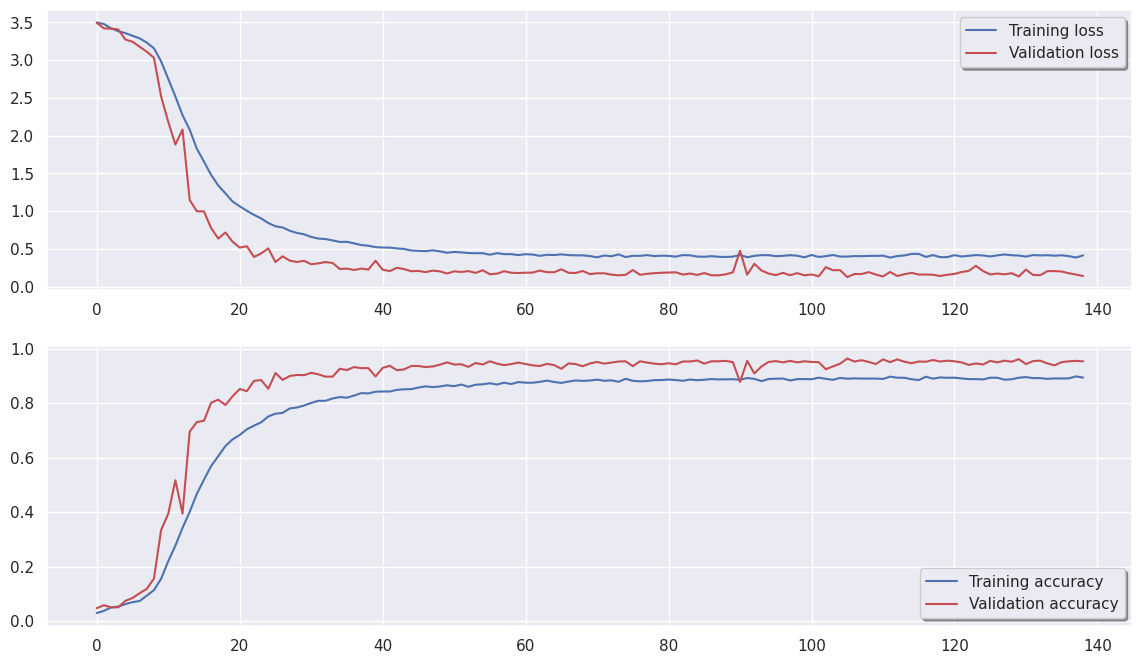

In [ ]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")  # График потерь на обучающем наборе данных
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])  # График потерь на валидационном наборе данных
legend = ax[0].legend(loc='best', shadow=True)  # Легенда для графика потерь

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")  # График точности на обучающем наборе данных
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")  # График точности на валидационном наборе данных
legend = ax[1].legend(loc='best', shadow=True)  # Легенда для графика точности

# Создание графиков потерь и точности
# Параметры:
# history.history['loss']: значения функции потерь на обучающем наборе данных
# history.history['val_loss']: значения функции потерь на валидационном наборе данных
# history.history['accuracy']: значения точности на обучающем наборе данных
# history.history['val_accuracy']: значения точности на валидационном наборе данных

# Легенда и тени для каждого графика
# ax[0]: первый подграфик для графика потерь
# ax[1]: второй подграфик для графика точности

In [ ]:
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Test: 0.952


45/45 [==============================] - 3s 68ms/step


<Axes: >

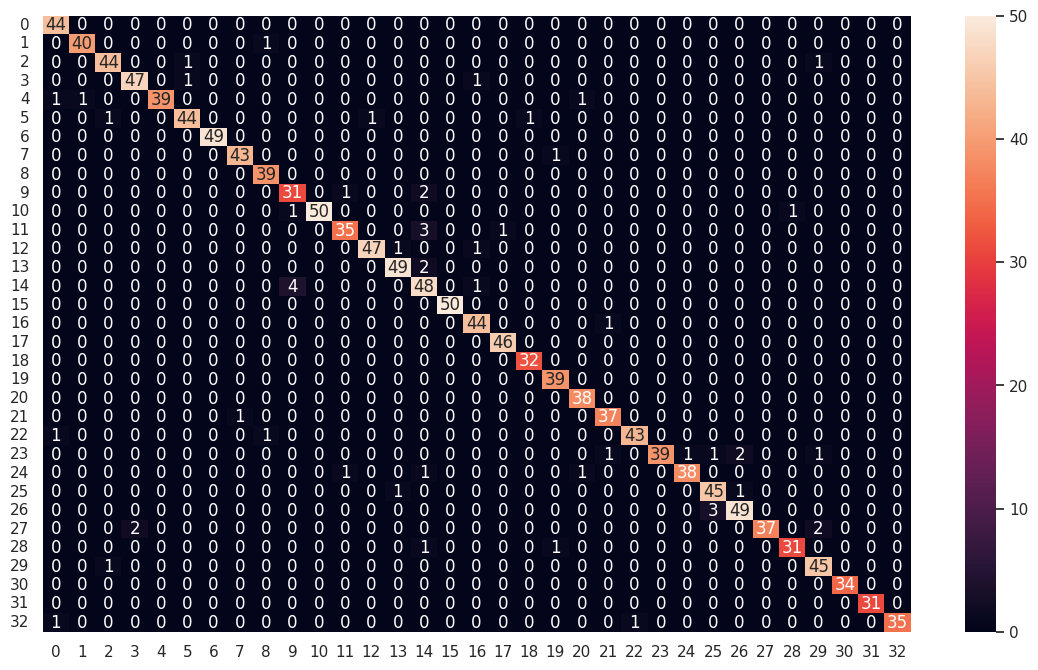

In [ ]:
y_pred = deep_RU_model.predict(X_test)# Получение предсказаний модели для тестовых данных X_test
y_pred = np.argmax(y_pred, axis=1)# Преобразование предсказаний в индексы с наибольшим значением (классы)
y_test = np.argmax(y_test, axis=1)# Преобразование истинных меток y_test в индексы с наибольшим значением (классы)
confusion_mtx = confusion_matrix(y_test, y_pred)# Вычисление матрицы ошибок между истинными метками y_test и предсказанными метками y_pred
sns.heatmap(confusion_mtx, annot=True, fmt='d')
# Параметры:
# confusion_mtx: матрица ошибок
# annot=True: отображение значений в клетках тепловой карты
# fmt='d': формат чисел в клетках - десятичное целое число

45/45 [==============================] - 3s 66ms/step


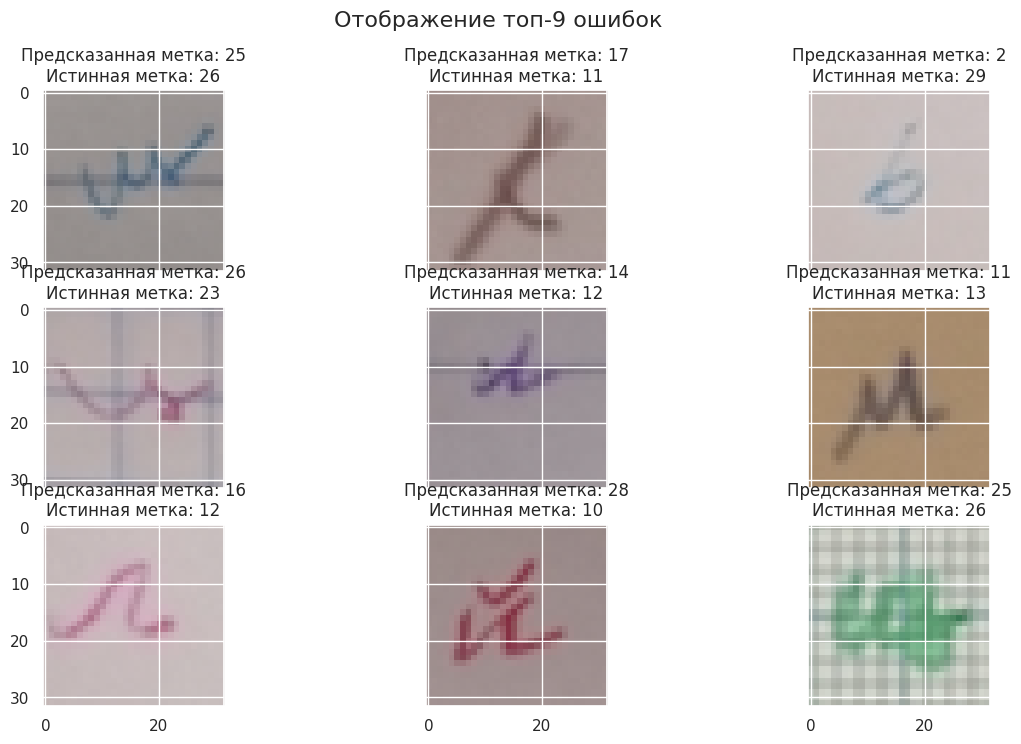

In [ ]:
# Преобразование меток из формата one-hot в исходный формат меток
Y_true = y_test
# Предсказание значений на тестовом наборе данных с помощью сохраненной модели
Y_pred = saved_model.predict(X_test)
# Преобразование предсказанных значений из формата one-hot в исходный формат меток
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Вычисление ошибок путем сравнения предсказанных меток с истинными метками
errors = (Y_pred_classes - Y_true != 0)
# Получение предсказанных меток для ошибочных предсказаний
Y_pred_classes_errors = Y_pred_classes[errors]
# Получение предсказанных значений для ошибочных предсказаний
Y_pred_errors = Y_pred[errors]
# Получение истинных меток для ошибочных предсказаний
Y_true_errors = Y_true[errors]
# Получение изображений, соответствующих ошибочным предсказаниям
X_val_errors = X_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """Функция отображает 9 изображений с предсказанными и истинными метками"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    fig.suptitle("Отображение топ-9 ошибок", fontsize=16)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]))
            ax[row, col].set_title("Предсказанная метка: {}\nИстинная метка: {}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Вероятности неправильно предсказанных символов
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
# Предсказанные вероятности истинных значений в ошибочном наборе
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
# Разница между вероятностью предсказанной метки и истинной меткой
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# Сортированный список ошибок по возрастанию разницы вероятностей
sorted_delta_errors = np.argsort(delta_pred_true_errors)
# Топ-9 ошибок
most_important_errors = sorted_delta_errors[-9:]
# Отображение топ-9 ошибок
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


В процессе обработки данных мы сместили порядок букв на 1, чтобы он начинался с 0. Новый порядок выглядит следующим образом:

а=>0, б=>1, в=>2, г=>3, д=>4, е=>5, ё=>6, ж=>7

з=>8, и=>9, й=>10, к=>11, л=>12, м=>13, н=>14

о=>15, п=>16, р=>17, с=>18, т=>19, у=>20, ф=>21

х=>22, ц=>23, ч=>24, ш=>25, щ=>26, ъ=>27, ы=>28

ь=>29, э=>30, ю=>31, я=>32

Большинство ошибок, особенно во втором ряду, легко может быть сделано человеком таким же образом.